In [1]:
#Basic imports
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import time
import joblib

import helpers as helpers

# Data Processing

In [2]:
# Import data
data1 = pd.read_excel('data.xlsx', 'Timepoint 1', header=1)
data2 = pd.read_excel('data2.xlsx', 'Sheet1', header=0)

In [3]:
data2['Date of birth'] = pd.to_datetime(data2['Date of birth'].astype(str), format='%d/%m/%Y')
data2['Date of MRI scan'] = pd.to_datetime(data2['Date of MRI scan'].astype(str), format='%Y-%m-%d', errors='ignore')
data2['Age'] = (data2['Date of MRI scan'] - data2['Date of birth'])/ np.timedelta64(1, 'Y')

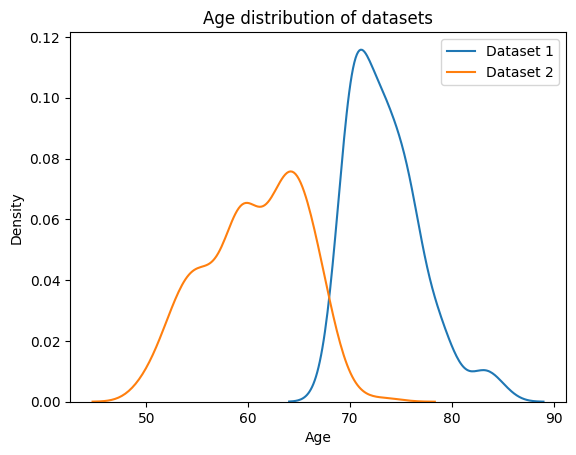

Dataset1 : (133 samples, 335 features)
Dataset2 : (232 samples, 175 features)


In [4]:
sns.kdeplot(
    data1,
    x='Age',
    label='Dataset 1'
).set_title("Age distribution of datasets")

sns.kdeplot(
    data2,
    x='Age',
    label='Dataset 2'
)

plt.legend()
plt.show()

print(f'Dataset1 : ({data1.shape[0]} samples, {data1.shape[1]} features)')
print(f'Dataset2 : ({data2.shape[0]} samples, {data2.shape[1]} features)')

## Format dataset 1

In [5]:
data_train1, data_test1, y_train1, y_test1 = train_test_split(data1.drop(['Age'], axis=1), data1['Age'], test_size=0.3, random_state=2)
x_train1, del_col1, mean_train1, std_train1 = helpers.clean_data(1, data_train1)
x_test1, _, _, _ = helpers.clean_data(1, data_test1, del_col1, mean_train1, std_train1)

In [6]:
x_train1 = x_train1.reset_index(drop=True)
x_test1 = x_test1.reset_index(drop=True)
y_train1 = pd.DataFrame(data=y_train1, columns=['Age']).reset_index(drop=True)
y_test1 = pd.DataFrame(data=y_test1, columns=['Age']).reset_index(drop=True)

## Format dataset 2

In [7]:
data_train2, data_test2, y_train2, y_test2 = train_test_split(data2.drop(['Age'], axis=1), data2['Age'], test_size=0.3, random_state=2)
x_train2, del_col2, mean_train2, std_train2 = helpers.clean_data(2, data_train2)
x_test2, _, _, _ = helpers.clean_data(2, data_test2, del_col2, mean_train2, std_train2)

In [8]:
x_train2 = x_train2.reset_index(drop=True)
x_test2 = x_test2.reset_index(drop=True)
y_train2 = pd.DataFrame(data=y_train2, columns=['Age']).reset_index(drop=True)
y_test2 = pd.DataFrame(data=y_test2, columns=['Age']).reset_index(drop=True)

## Select dataset

In [9]:
i_data = 1

if (i_data == 1):
    x_train = x_train1
    x_test = x_test1
    y_train = y_train1
    y_test = y_test1
elif (i_data == 2):
    x_train = x_train2
    x_test = x_test2
    y_train = y_train2
    y_test = y_test2

### Models

In [10]:
from sklearn import svm
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

# Create grids for search parameters
param_grid_svm = [
    {'clf__C': np.logspace(-3, 3, 10), 'clf__kernel': ['linear']},
    {'clf__C': np.logspace(-3, 3, 10), 'clf__gamma': np.logspace(-10, 0, 20), 'clf__kernel': ['rbf']},
]

param_grid_elastic = {
    'clf__alpha': np.logspace(-10,7,25),
    'clf__l1_ratio': np.append(np.logspace(-10,0,20), 0)
}

param_grid_adaboost = {
    'clf__n_estimators': np.arange(1, 200, 20),
    'clf__learning_rate': [1.0, 0.5, 0.1]
}

param_grid_forest = {
    'clf__n_estimators': np.arange(10, 100, 20),
    'clf__max_depth': np.arange(1, 20)
}

param_grid_knn = {
    'clf__n_neighbors': np.arange(1, 20)
}


# Create models grid search
model_svr = helpers.model_gs(
    svm.SVR(),
    param_grid_svm
)

model_elastic = helpers.model_gs(
    ElasticNet(max_iter=5000),
    param_grid_elastic
)

model_adaboost = helpers.model_gs(
    AdaBoostRegressor(random_state = 123),
    param_grid_adaboost
)

model_forest = helpers.model_gs(
    RandomForestRegressor(),
    param_grid_forest
)

model_knn = helpers.model_gs(
    KNeighborsRegressor(),
    param_grid_knn
)

# Create models list
models = {
    "SVR": model_svr,
    "ElasticNet": model_elastic,
    "AdaBoost": model_adaboost,
    "RandomForest": model_forest,
    "KNN": model_knn
}


# PLS

In [11]:
# PLS Regression
pls_train, pls_test = helpers.PLS_regression(x_train, x_test, y_train, y_test, n_components = 20)

### Standardize

In [12]:
pls_train_scaled, pls_test_scaled = helpers.standardize(pls_train, pls_test)

### Filter MI Score

In [13]:
pls_train_scaled, pls_test_scaled = helpers.filter_mi_scores(pls_train_scaled, pls_test_scaled, y_train, 0)

### Clustering

In [14]:
pls_train_scaled, pls_test_scaled = helpers.KM_clustering(pls_train_scaled, pls_test_scaled, n_clusters=3)
#pls_train_scaled, pls_test_scaled = helpers.GMM_clustering(pls_train_scaled, pls_test_scaled, n_clusters=3)

c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [15]:
results_pls_global = helpers.train_all(pls_train_scaled, pls_test_scaled, y_train, y_test, models, plot=False)

Fitting 15 folds for each of 210 candidates, totalling 3150 fits
Fitting 15 folds for each of 525 candidates, totalling 7875 fits
Fitting 15 folds for each of 30 candidates, totalling 450 fits
Fitting 15 folds for each of 95 candidates, totalling 1425 fits
Fitting 15 folds for each of 19 candidates, totalling 285 fits


In [16]:
results_pls_cluster_0 = helpers.train_cluster(0, pls_train_scaled, pls_test_scaled, y_train, y_test, models, plot=False)
results_pls_cluster_1 = helpers.train_cluster(1, pls_train_scaled, pls_test_scaled, y_train, y_test, models, plot=False)
results_pls_cluster_2 = helpers.train_cluster(2, pls_train_scaled, pls_test_scaled, y_train, y_test, models, plot=False)

Fitting 15 folds for each of 210 candidates, totalling 3150 fits
Fitting 15 folds for each of 525 candidates, totalling 7875 fits
Fitting 15 folds for each of 30 candidates, totalling 450 fits
Fitting 15 folds for each of 95 candidates, totalling 1425 fits
Fitting 15 folds for each of 19 candidates, totalling 285 fits


c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [-0.45109469 -0.18498202 -0.00572451  0.20451302  0.25446138  0.32697635
  0.33797776  0.30207323  0.30672695  0.30057545  0.28614114  0.27263376
  0.21964039  0.13759289  0.09888096  0.01393505 -0.05378727 -0.13567855
         nan]
  warnings.warn(
c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the train scores are non-finite: [1.         0.77248375 0.68096804 0.58691028 0.55475449 0.50565638
 0.45688171 0.42302798 0.36776405 0.32753201 0.29683506 0.26639379
 0.22645064 0.18991134 0.15112557 0.11547554 0.07373773 0.02141678
        nan]
  warnings.warn(


Fitting 15 folds for each of 210 candidates, totalling 3150 fits
Fitting 15 folds for each of 525 candidates, totalling 7875 fits
Fitting 15 folds for each of 30 candidates, totalling 450 fits
Fitting 15 folds for each of 95 candidates, totalling 1425 fits
Fitting 15 folds for each of 19 candidates, totalling 285 fits
Fitting 15 folds for each of 210 candidates, totalling 3150 fits
Fitting 15 folds for each of 525 candidates, totalling 7875 fits
Fitting 15 folds for each of 30 candidates, totalling 450 fits
Fitting 15 folds for each of 95 candidates, totalling 1425 fits
Fitting 15 folds for each of 19 candidates, totalling 285 fits


In [17]:
results_pls_global

,Best score,Train R2,Test R2,Train MAE,Test MAE
SVR,0.875250,0.929125,-0.141497,0.673725,3.099315
ElasticNet,0.892625,0.922724,-0.101993,0.741389,3.067188
AdaBoost,0.517537,0.931520,0.075040,0.734198,2.782801
RandomForest,0.518894,0.944438,-0.012450,0.590323,2.917500
KNN,0.399964,0.731538,-0.033066,1.346774,2.737500


In [18]:
results_pls_cluster_0

,Best score,Train R2,Test R2,Train MAE,Test MAE
SVR,0.768469,0.941004,-0.073342,0.435212,2.590544
ElasticNet,0.803905,0.948954,-0.095828,0.546679,2.620294
AdaBoost,0.139751,0.970117,-0.082903,0.420946,2.327434
RandomForest,0.299485,0.907810,-0.022324,0.671429,2.304000
KNN,0.337978,0.573431,0.011154,1.454082,2.428571


In [19]:
results_pls_cluster_1

,Best score,Train R2,Test R2,Train MAE,Test MAE
SVR,0.754053,0.940545,-0.220536,0.507179,3.452131
ElasticNet,0.817886,0.947409,-0.321073,0.618647,3.609627
AdaBoost,0.483568,0.984036,-0.070348,0.270562,3.057557
RandomForest,0.403307,0.955687,-0.137468,0.542708,3.176667
KNN,0.263417,0.616459,-0.117266,1.671875,3.000000


In [20]:
results_pls_cluster_2

,Best score,Train R2,Test R2,Train MAE,Test MAE
SVR,0.806907,0.978109,0.290924,0.323294,1.852079
ElasticNet,0.827398,0.931224,0.452264,0.737093,1.684856
AdaBoost,0.396628,0.977255,-0.769926,0.389048,3.669608
RandomForest,0.466889,0.948632,-0.280721,0.648485,3.168889
KNN,0.253650,0.687746,0.144345,1.505051,2.466667


# PCA

In [21]:
pc_train, pc_test = helpers.PCA_decomposition(x_train, x_test, y_train, y_test, n_components=20)

### Standardize

In [22]:
pc_train_scaled, pc_test_scaled = helpers.standardize(pc_train, pc_test)

### Clustering

In [23]:
pc_train_scaled, pc_test_scaled = helpers.KM_clustering(pc_train_scaled, pc_test_scaled, n_clusters=3)
#pc_train_scaled, pc_test_scaled = helpers.GMM_clustering(pc_train_scaled, pc_test_scaled, n_clusters=3)

c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [24]:
results_pca_global = helpers.train_all(pc_train_scaled, pc_test_scaled, y_train, y_test, models, plot=False)

Fitting 15 folds for each of 210 candidates, totalling 3150 fits
Fitting 15 folds for each of 525 candidates, totalling 7875 fits


c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.919e+02, tolerance: 1.130e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Fitting 15 folds for each of 30 candidates, totalling 450 fits
Fitting 15 folds for each of 95 candidates, totalling 1425 fits
Fitting 15 folds for each of 19 candidates, totalling 285 fits


In [25]:
results_pca_cluster_0 = helpers.train_cluster(0, pc_train_scaled, pc_test_scaled, y_train, y_test, models, plot=False)
results_pca_cluster_1 = helpers.train_cluster(1, pc_train_scaled, pc_test_scaled, y_train, y_test, models, plot=False)
results_pca_cluster_2 = helpers.train_cluster(2, pc_train_scaled, pc_test_scaled, y_train, y_test, models, plot=False)

Fitting 15 folds for each of 210 candidates, totalling 3150 fits
Fitting 15 folds for each of 525 candidates, totalling 7875 fits
Fitting 15 folds for each of 30 candidates, totalling 450 fits
Fitting 15 folds for each of 95 candidates, totalling 1425 fits
Fitting 15 folds for each of 19 candidates, totalling 285 fits
Fitting 15 folds for each of 210 candidates, totalling 3150 fits


c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Fitting 15 folds for each of 525 candidates, totalling 7875 fits


c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Fitting 15 folds for each of 30 candidates, totalling 450 fits


c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Fitting 15 folds for each of 95 candidates, totalling 1425 fits


c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


Fitting 15 folds for each of 19 candidates, totalling 285 fits


c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [-1.21484433 -1.45885476 -2.15621571 -1.92461061 -3.36634731         nan
         nan         nan         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan]
  warnings.warn(
c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the train scores are non-finite: [1.         0.63949044 0.36216616 0.23249916 0.07280011        nan
        nan        nan        nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan]
  warnings.warn(
c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\metrics\_regression.py:918: UndefinedMetricWarning: R^2 score is not well-defined with less th

Fitting 15 folds for each of 210 candidates, totalling 3150 fits
Fitting 15 folds for each of 525 candidates, totalling 7875 fits


c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.610e+02, tolerance: 3.620e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Fitting 15 folds for each of 30 candidates, totalling 450 fits
Fitting 15 folds for each of 95 candidates, totalling 1425 fits
Fitting 15 folds for each of 19 candidates, totalling 285 fits


In [26]:
results_pca_global

,Best score,Train R2,Test R2,Train MAE,Test MAE
SVR,0.149803,0.856950,0.104528,0.527668,2.698484
ElasticNet,0.095890,0.445216,0.209084,1.972313,2.649144
AdaBoost,0.044122,0.852893,0.143816,1.170720,2.736672
RandomForest,0.059102,0.857975,0.137500,1.034857,2.747497
KNN,-0.086758,0.186527,0.089450,2.273297,2.693750


In [27]:
results_pca_cluster_0

,Best score,Train R2,Test R2,Train MAE,Test MAE
SVR,0.082149,0.911698,0.118997,0.500870,2.431879
ElasticNet,-0.034722,0.429056,0.002493,1.961177,2.548807
AdaBoost,-0.156578,0.949463,-0.134714,0.648378,2.897364
RandomForest,-0.143367,0.444697,-0.037696,2.071082,2.654796
KNN,-0.070271,0.027821,-0.024707,2.506757,2.640625


In [28]:
results_pca_cluster_1

,Best score,Train R2,Test R2,Train MAE,Test MAE
SVR,-1.355256,0.680850,NaN,1.334270,0.295962
ElasticNet,-0.601424,1.000000,NaN,0.002162,2.200500
AdaBoost,-0.959224,0.993750,NaN,0.125000,0.000000
RandomForest,-0.684504,0.806104,NaN,1.554167,0.523333
KNN,-1.214844,1.000000,NaN,0.000000,2.000000


In [29]:
results_pca_cluster_2

,Best score,Train R2,Test R2,Train MAE,Test MAE
SVR,0.000237,0.648274,-0.110164,0.667479,3.113053
ElasticNet,-0.027074,0.195380,-0.000936,1.861370,2.976239
AdaBoost,-0.032755,0.928994,0.000253,0.587179,3.030796
RandomForest,-0.029812,0.857265,0.086856,0.787269,2.899034
KNN,-0.024934,0.192016,-0.006753,1.766026,3.010033


# Raw

### Clustering

In [30]:
raw_train_scaled, raw_test_scaled = helpers.KM_clustering(x_train, x_test, n_clusters=3) 

c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [31]:
results_raw_global = helpers.train_all(raw_train_scaled, raw_test_scaled, y_train, y_test, models, plot=False)

Fitting 15 folds for each of 210 candidates, totalling 3150 fits
Fitting 15 folds for each of 525 candidates, totalling 7875 fits
Fitting 15 folds for each of 30 candidates, totalling 450 fits
Fitting 15 folds for each of 95 candidates, totalling 1425 fits
Fitting 15 folds for each of 19 candidates, totalling 285 fits


In [32]:
results_raw_cluster_0 = helpers.train_cluster(0, raw_train_scaled, raw_test_scaled, y_train, y_test, models, plot=False)
results_raw_cluster_1 = helpers.train_cluster(1, raw_train_scaled, raw_test_scaled, y_train, y_test, models, plot=False)
results_raw_cluster_2 = helpers.train_cluster(2, raw_train_scaled, raw_test_scaled, y_train, y_test, models, plot=False)

Fitting 15 folds for each of 210 candidates, totalling 3150 fits
Fitting 15 folds for each of 525 candidates, totalling 7875 fits


c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.741e-02, tolerance: 5.120e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Fitting 15 folds for each of 30 candidates, totalling 450 fits
Fitting 15 folds for each of 95 candidates, totalling 1425 fits
Fitting 15 folds for each of 19 candidates, totalling 285 fits
Fitting 15 folds for each of 210 candidates, totalling 3150 fits
Fitting 15 folds for each of 525 candidates, totalling 7875 fits
Fitting 15 folds for each of 30 candidates, totalling 450 fits
Fitting 15 folds for each of 95 candidates, totalling 1425 fits
Fitting 15 folds for each of 19 candidates, totalling 285 fits
Fitting 15 folds for each of 210 candidates, totalling 3150 fits
Fitting 15 folds for each of 525 candidates, totalling 7875 fits
Fitting 15 folds for each of 30 candidates, totalling 450 fits
Fitting 15 folds for each of 95 candidates, totalling 1425 fits
Fitting 15 folds for each of 19 candidates, totalling 285 fits


c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [-1.54302881 -0.57990449 -0.36663824 -0.24404079 -0.07183804 -0.10314303
 -0.41618374 -1.06105707         nan         nan         nan         nan
         nan         nan         nan         nan         nan         nan
         nan]
  warnings.warn(
c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the train scores are non-finite: [1.         0.67672662 0.5854747  0.49909963 0.3866256  0.26178635
 0.16281871 0.                nan        nan        nan        nan
        nan        nan        nan        nan        nan        nan
        nan]
  warnings.warn(


In [33]:
results_raw_global

,Best score,Train R2,Test R2,Train MAE,Test MAE
SVR,0.253368,0.947257,-0.081751,0.296401,3.112619
ElasticNet,0.242395,0.987845,-0.182742,0.294455,3.276554
AdaBoost,-0.037996,0.882102,0.045566,1.026087,2.901213
RandomForest,-0.055412,0.886865,0.065693,0.924516,2.920500
KNN,-0.078388,0.372255,0.033620,2.019713,2.870833


In [34]:
results_raw_cluster_0

,Best score,Train R2,Test R2,Train MAE,Test MAE
SVR,0.159833,0.966974,0.151305,0.230943,2.701762
ElasticNet,0.142601,1.000000,0.130703,0.000787,2.690017
AdaBoost,-0.077898,0.982246,0.127708,0.346582,2.735088
RandomForest,-0.078238,0.875094,0.049753,0.996748,2.787500
KNN,-0.119565,0.204252,0.113675,2.395872,2.740385


In [35]:
results_raw_cluster_1

,Best score,Train R2,Test R2,Train MAE,Test MAE
SVR,0.129430,0.951410,0.149848,0.252068,2.678297
ElasticNet,0.117679,1.000000,-0.012095,0.000135,2.742630
AdaBoost,-0.142137,0.982532,0.130630,0.301425,2.360295
RandomForest,-0.066718,0.841989,0.122245,0.988056,2.645679
KNN,0.018920,0.274815,-0.020384,2.020833,2.842593


In [36]:
results_raw_cluster_2

,Best score,Train R2,Test R2,Train MAE,Test MAE
SVR,0.161653,0.958096,-0.275062,0.311461,3.089421
ElasticNet,0.192727,0.999970,0.048306,0.016913,2.769921
AdaBoost,-0.445217,1.000000,-0.347409,0.000000,3.166667
RandomForest,-0.267052,0.864130,-0.025740,0.989815,2.955556
KNN,-0.071838,0.514896,-0.785950,1.900000,3.766667


# Lasso Feature Selection

In [37]:
# data1 : thr=0.2, data2 : thr=0
lasso_train, lasso_test = helpers.filter_lasso(x_train, x_test, y_train, threshold=0.2)

c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:1561: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Lasso picked 40 variables and eliminated the other 255 variables


c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.581e-01, tolerance: 1.130e-01
  model = cd_fast.enet_coordinate_descent(


### Clustering

In [38]:
lasso_train, lasso_test = helpers.KM_clustering(lasso_train, lasso_test, n_clusters=3)
#lasso_train, lasso_test = helpers.GMM_clustering(lasso_train, lasso_test, n_clusters=2)

c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [39]:
results_lasso_global = helpers.train_all(lasso_train, lasso_test, y_train, y_test, models, plot=False)

Fitting 15 folds for each of 210 candidates, totalling 3150 fits
Fitting 15 folds for each of 525 candidates, totalling 7875 fits


c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.719e+01, tolerance: 1.130e-01 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Fitting 15 folds for each of 30 candidates, totalling 450 fits
Fitting 15 folds for each of 95 candidates, totalling 1425 fits
Fitting 15 folds for each of 19 candidates, totalling 285 fits


In [40]:
results_lasso_cluster_0 = helpers.train_cluster(0, lasso_train, lasso_test, y_train, y_test, models, plot=False)
results_lasso_cluster_1 = helpers.train_cluster(1, lasso_train, lasso_test, y_train, y_test, models, plot=False)
results_lasso_cluster_2 = helpers.train_cluster(2, lasso_train, lasso_test, y_train, y_test, models, plot=False)

Fitting 15 folds for each of 210 candidates, totalling 3150 fits
Fitting 15 folds for each of 525 candidates, totalling 7875 fits


c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.644e+01, tolerance: 3.660e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Fitting 15 folds for each of 30 candidates, totalling 450 fits
Fitting 15 folds for each of 95 candidates, totalling 1425 fits
Fitting 15 folds for each of 19 candidates, totalling 285 fits
Fitting 15 folds for each of 210 candidates, totalling 3150 fits
Fitting 15 folds for each of 525 candidates, totalling 7875 fits
Fitting 15 folds for each of 30 candidates, totalling 450 fits
Fitting 15 folds for each of 95 candidates, totalling 1425 fits
Fitting 15 folds for each of 19 candidates, totalling 285 fits


c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the test scores are non-finite: [ 0.06302853  0.13882753  0.20307204  0.20525708  0.23307547  0.18531263
  0.15660027  0.13966241  0.12897597  0.11859472  0.08761928  0.05283715
  0.03365372  0.00296591 -0.0297554  -0.04596888 -0.07359165 -0.10611932
         nan]
  warnings.warn(
c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\model_selection\_search.py:953: UserWarning: One or more of the train scores are non-finite: [1.         0.77090219 0.61678195 0.51402636 0.41810622 0.36699085
 0.33926939 0.29963057 0.26731378 0.23946598 0.19967585 0.16628561
 0.13654427 0.11167479 0.08456986 0.05868162 0.03865291 0.02110969
        nan]
  warnings.warn(


Fitting 15 folds for each of 210 candidates, totalling 3150 fits
Fitting 15 folds for each of 525 candidates, totalling 7875 fits


c:\users\anton\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:634: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.668e+01, tolerance: 2.857e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(


Fitting 15 folds for each of 30 candidates, totalling 450 fits
Fitting 15 folds for each of 95 candidates, totalling 1425 fits
Fitting 15 folds for each of 19 candidates, totalling 285 fits


In [41]:
results_lasso_global

,Best score,Train R2,Test R2,Train MAE,Test MAE
SVR,0.830468,0.966649,-0.021281,0.378866,3.014441
ElasticNet,0.839701,0.967177,-0.065436,0.487145,3.038228
AdaBoost,0.116188,0.899470,0.021552,0.965120,2.974360
RandomForest,0.062492,0.894595,0.020255,0.899247,2.909421
KNN,0.131767,0.587217,0.054588,1.720430,2.840000


In [42]:
results_lasso_cluster_0

,Best score,Train R2,Test R2,Train MAE,Test MAE
SVR,0.377365,0.999071,0.165250,0.100012,2.352279
ElasticNet,0.381467,0.955153,0.169096,0.536172,2.363726
AdaBoost,-0.154648,0.974646,0.058729,0.402165,2.666754
RandomForest,-0.053074,0.478338,-0.000112,1.900892,2.758333
KNN,0.090138,0.484850,-0.261179,1.835294,3.042857


In [43]:
results_lasso_cluster_1

,Best score,Train R2,Test R2,Train MAE,Test MAE
SVR,0.530314,0.999238,0.222279,0.105163,2.615324
ElasticNet,0.534761,1.000000,0.190617,0.001326,2.609755
AdaBoost,-0.011258,0.979830,0.067586,0.362090,3.164023
RandomForest,-0.002333,0.872360,-0.004063,1.122143,3.369231
KNN,0.233075,0.556591,0.052553,1.885714,3.169231


In [44]:
results_lasso_cluster_2

,Best score,Train R2,Test R2,Train MAE,Test MAE
SVR,0.221787,0.867763,-0.216395,0.387094,3.383254
ElasticNet,0.154567,0.793792,0.050710,1.173765,2.899251
AdaBoost,-0.038448,0.981273,0.105081,0.271638,2.720330
RandomForest,0.063717,0.886082,-0.148547,0.823502,3.027473
KNN,0.063199,0.638676,-0.423183,1.365591,3.333333
